In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
master_df = pd.read_csv('data/features_nltk.csv')
df = master_df.copy()

# Word2Vec Embeddings

In [9]:
from gensim.models import Word2Vec

In [19]:
df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",''))

df['tokenized_text_nltk'] = df['tokenized_text_nltk'].apply(lambda x: x.split())

In [48]:
sentences = df['tokenized_text_nltk'].tolist()

embed_size = 100
max_features = 20000
maxlen = 50
w2v_model = Word2Vec(sentences=sentences, vector_size=embed_size, window=5, min_count=1)

In [49]:
len(w2v_model.wv)

28337

In [50]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
tokenized_train = tokenizer.texts_to_sequences(sentences)

x = pad_sequences(tokenized_train, maxlen=maxlen)

In [51]:
vocab_size = len(w2v_model.wv) + 1 #for the zero-indexed unknown words

In [52]:
def get_weight_mat(model, vocab):
    vocab_size = len(vocab) + 1 #for unknown words
    weights = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        weights[i] = model[word]
    return weights

In [53]:
embedding_vecs = get_weight_mat(w2v_model.wv, tokenizer.word_index)

# Unidirectional LSTM

In [114]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, weights=[embedding_vecs], trainable=False))
model.add(LSTM(units=64, dropout=0.3, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc', 'f1_score', 'precision', 'recall'])

In [115]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │     2,833,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,833,800 (10.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,833,800 (10.81 MB)

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x, df['is_sarcastic'], test_size=0.2, random_state=42)

In [118]:
history = model.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - acc: 0.5940 - f1_score: 0.6104 - loss: 0.6670 - precision: 0.5607 - recall: 0.3260 - val_acc: 0.6878 - val_f1_score: 0.6103 - val_loss: 0.5907 - val_precision: 0.5967 - val_recall: 0.8913
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - acc: 0.6667 - f1_score: 0.6120 - loss: 0.6025 - precision: 0.6291 - recall: 0.5938 - val_acc: 0.7063 - val_f1_score: 0.6103 - val_loss: 0.5575 - val_precision: 0.6346 - val_recall: 0.7809
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - acc: 0.6967 - f1_score: 0.6106 - loss: 0.5653 - precision: 0.6480 - recall: 0.6786 - val_acc: 0.7244 - val_f1_score: 0.6103 - val_loss: 0.5285 - val_precision: 0.6682 - val_recall: 0.7400
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - acc: 0.7014 - f1_score: 0.6136 - loss: 0.5509 - precision: 0.6531 - recall: 0.6940 - val_acc: 0.7263 - val_f1_score: 0.6103 - val_loss: 0.5315 - val_precision: 0.6471 - val_recall: 0.8286
Epoch 5/5
167/167 ━━━━━━━━━━━━━━

In [122]:
model.evaluate(x_test,y_test)[1:]

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7358 - f1_score: 0.6122 - loss: 0.5259 - precision: 0.7018 - recall: 0.6981


[0.7401722073554993,
 0.6103017330169678,
 0.7015992999076843,
 0.7105711698532104]

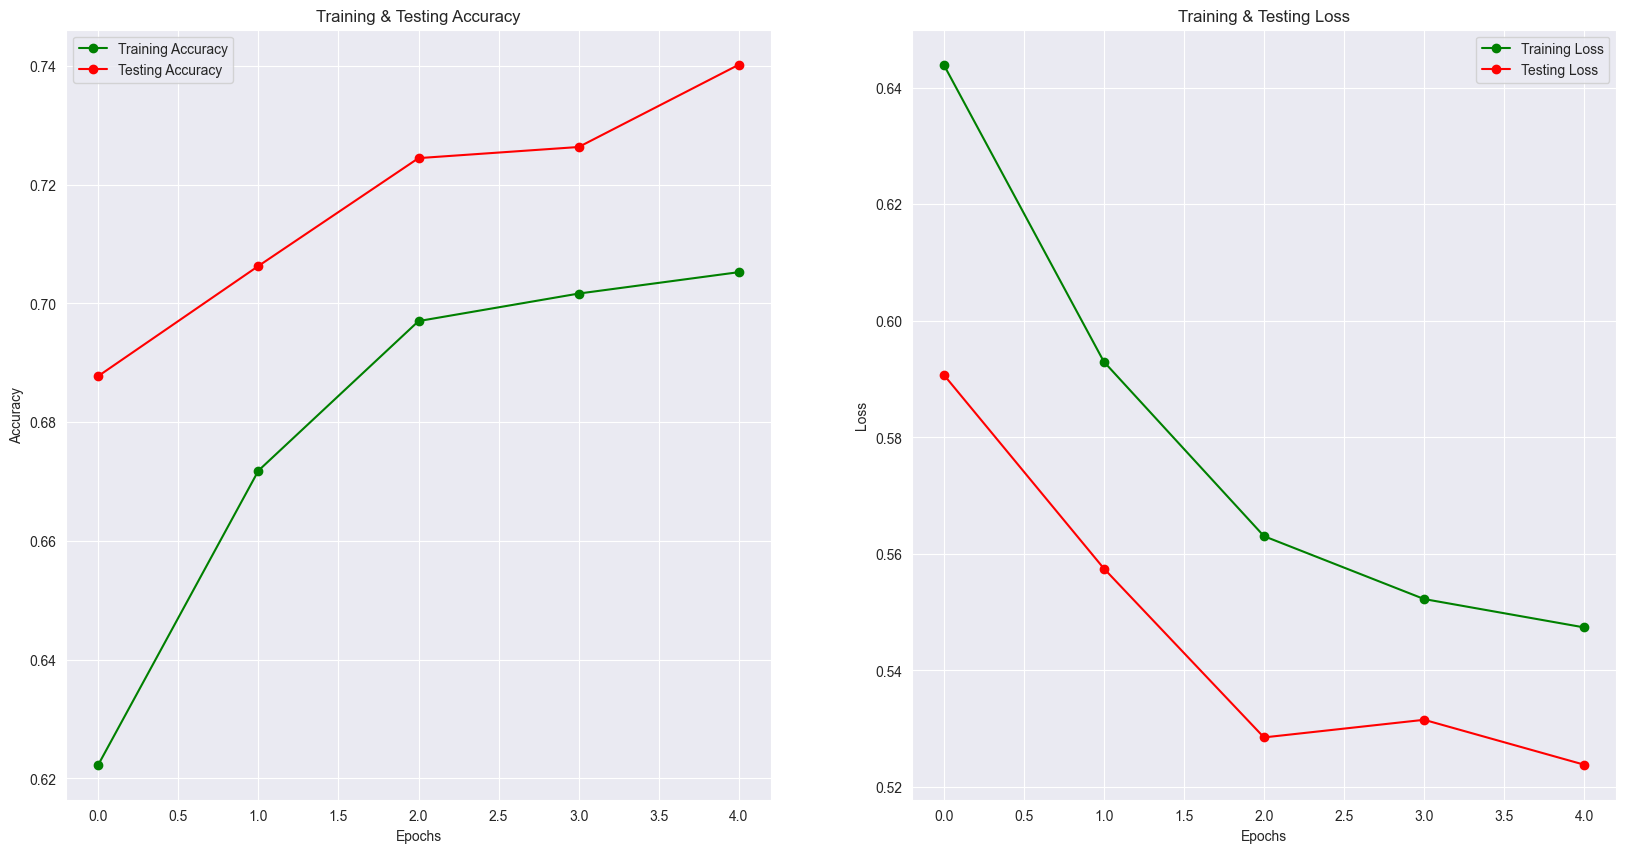

In [123]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Bidirectional LSTM

In [124]:
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(vocab_size, embed_size, weights=[embedding_vecs], trainable=False))
model_bidirectional.add(Bidirectional(LSTM(units=64, dropout=0.3, recurrent_dropout=0.2, return_sequences=False)))
model_bidirectional.add(Dense(1, activation='sigmoid'))
model_bidirectional.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc', 'f1_score', 'precision', 'recall'])

In [125]:
history_bidirectional = model_bidirectional.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - acc: 0.5673 - f1_score: 0.6116 - loss: 0.6777 - precision: 0.5193 - recall: 0.2795 - val_acc: 0.6803 - val_f1_score: 0.6103 - val_loss: 0.5993 - val_precision: 0.5984 - val_recall: 0.8269
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - acc: 0.6650 - f1_score: 0.6114 - loss: 0.6064 - precision: 0.6260 - recall: 0.5945 - val_acc: 0.7134 - val_f1_score: 0.6103 - val_loss: 0.5453 - val_precision: 0.6304 - val_recall: 0.8397
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - acc: 0.6925 - f1_score: 0.6058 - loss: 0.5703 - precision: 0.6427 - recall: 0.6588 - val_acc: 0.7261 - val_f1_score: 0.6103 - val_loss: 0.5224 - val_precision: 0.6704 - val_recall: 0.7404
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - acc: 0.6994 - f1_score: 0.6061 - loss: 0.5543 - precision: 0.6444 - recall: 0.6892 - val_acc: 0.7317 - val_f1_score: 0.6103 - val_loss: 0.5169 - val_precision: 0.6588 - val_recall: 0.8073
Epoch 5/5
167/167 ━━━━━━━━━━

In [126]:
model_bidirectional.evaluate(x_test, y_test)[1:]

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.7358 - f1_score: 0.6122 - loss: 0.5085 - precision: 0.6829 - recall: 0.7487


[0.7373642921447754,
 0.6103017330169678,
 0.6808592081069946,
 0.7566069960594177]

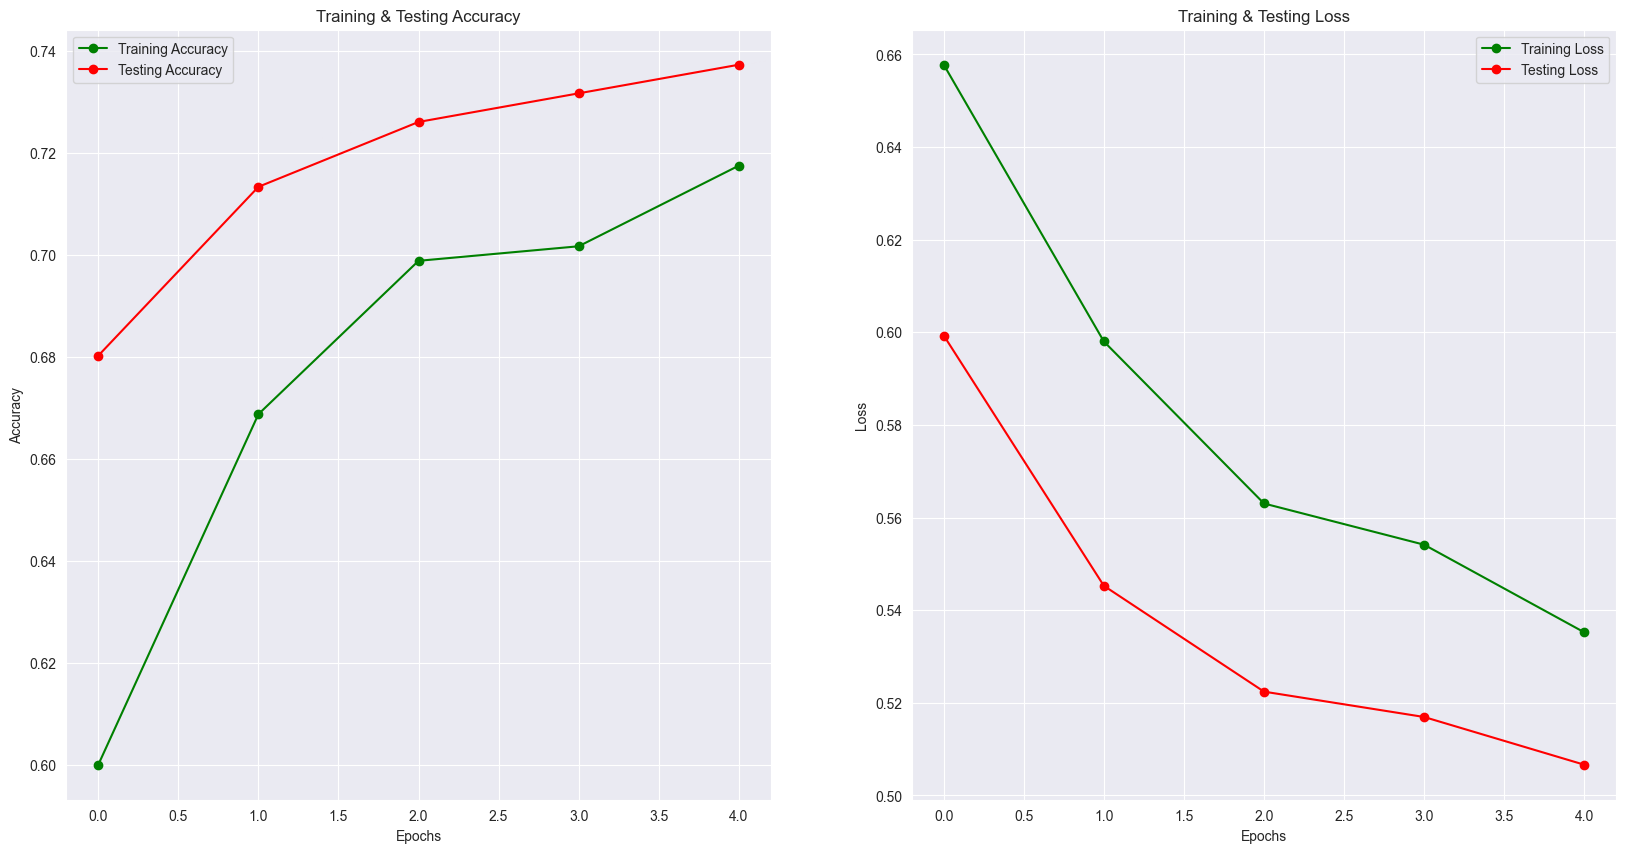

In [127]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_bidirectional.history['acc']
train_loss = history_bidirectional.history['loss']
val_acc = history_bidirectional.history['val_acc']
val_loss = history_bidirectional.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Unidirectional GRU

In [110]:
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, embed_size, weights=[embedding_vecs], trainable=False))
model_gru.add(GRU(units=64, dropout=0.3, return_sequences=False))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc', 'f1_score', 'precision', 'recall'])

In [111]:
history_gru = model_gru.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - acc: 0.5692 - f1_score: 0.6150 - loss: 0.6766 - precision: 0.5269 - recall: 0.2840 - val_acc: 0.6741 - val_f1_score: 0.6103 - val_loss: 0.6014 - val_precision: 0.6122 - val_recall: 0.7033
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - acc: 0.6631 - f1_score: 0.6075 - loss: 0.6017 - precision: 0.6155 - recall: 0.6060 - val_acc: 0.7110 - val_f1_score: 0.6103 - val_loss: 0.5480 - val_precision: 0.6240 - val_recall: 0.8602
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - acc: 0.6931 - f1_score: 0.6100 - loss: 0.5640 - precision: 0.6426 - recall: 0.6779 - val_acc: 0.6769 - val_f1_score: 0.6103 - val_loss: 0.5570 - val_precision: 0.7399 - val_recall: 0.4075
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.7040 - f1_score: 0.6110 - loss: 0.5437 - precision: 0.6568 - recall: 0.6897 - val_acc: 0.7381 - val_f1_score: 0.6103 - val_loss: 0.5154 - val_precision: 0.6726 - val_recall: 0.7864
Epoch 5/5
167/167 ━━━━━━━━━━━━━━

In [112]:
model_gru.evaluate(x_test, y_test)[1:]

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7427 - f1_score: 0.6122 - loss: 0.5096 - precision: 0.6876 - recall: 0.7651


[0.7429801821708679,
 0.6103017330169678,
 0.6853333115577698,
 0.7668371796607971]

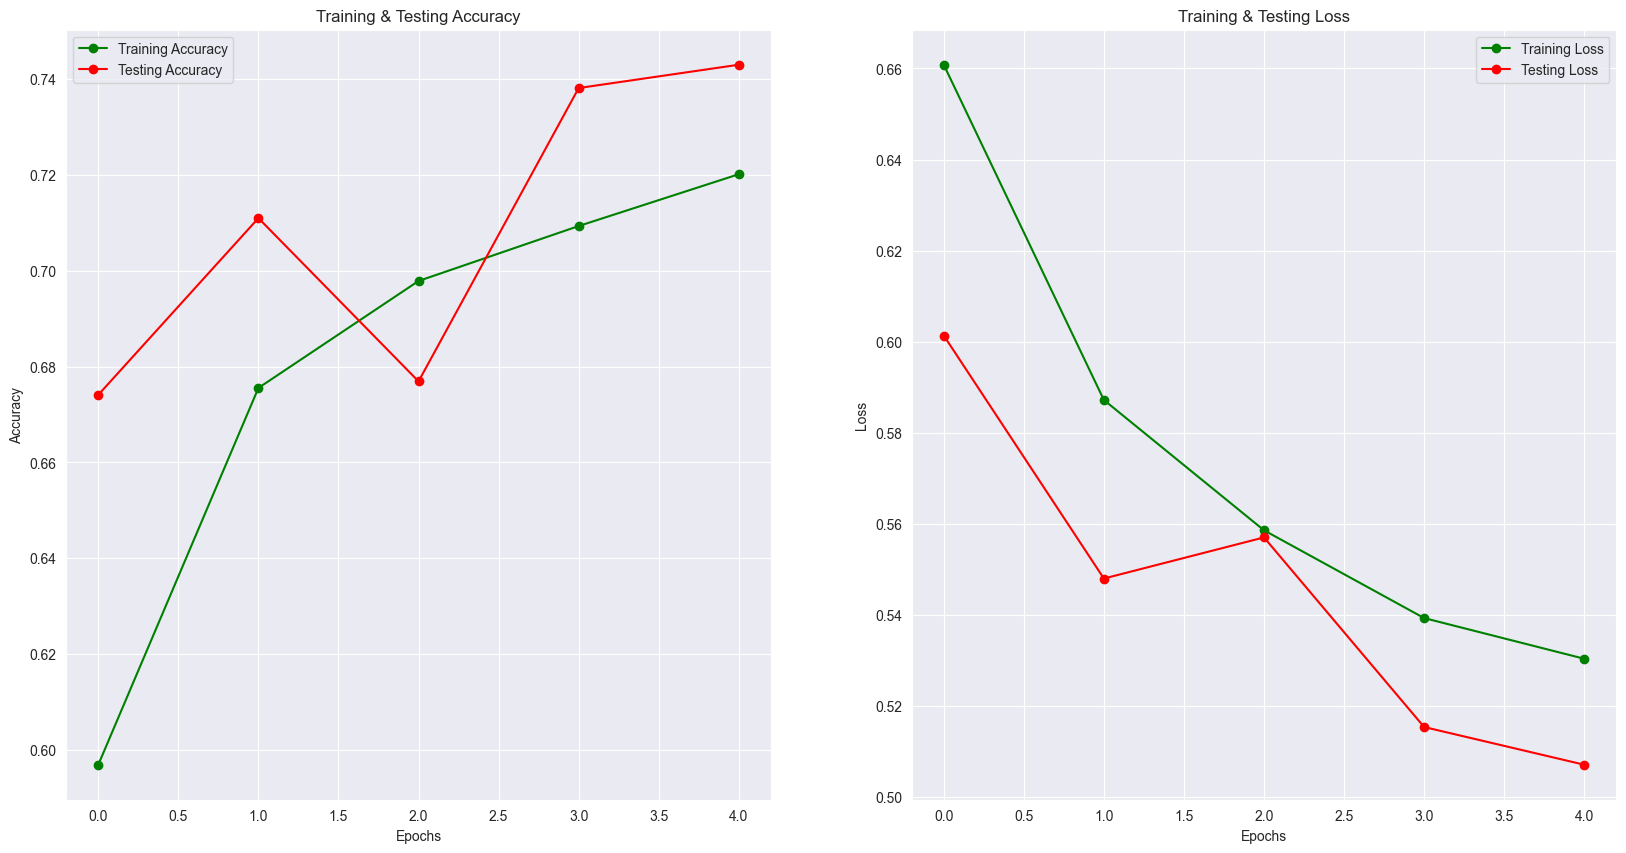

In [113]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_gru.history['acc']
train_loss = history_gru.history['loss']
val_acc = history_gru.history['val_acc']
val_loss = history_gru.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Bidirectional GRU

In [128]:
model_gru_bi = Sequential()
model_gru_bi.add(Embedding(vocab_size, embed_size, weights=[embedding_vecs], trainable=False))
model_gru_bi.add(Bidirectional(GRU(units=64, dropout=0.3, return_sequences=False)))
model_gru_bi.add(Dense(1, activation='sigmoid'))
model_gru_bi.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc', 'f1_score', 'precision', 'recall'])

In [129]:
history_gru_bi = model_gru_bi.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 5)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - acc: 0.5728 - f1_score: 0.6114 - loss: 0.6754 - precision: 0.5292 - recall: 0.2506 - val_acc: 0.6896 - val_f1_score: 0.6103 - val_loss: 0.5885 - val_precision: 0.6164 - val_recall: 0.7766
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - acc: 0.6730 - f1_score: 0.6143 - loss: 0.5908 - precision: 0.6285 - recall: 0.6402 - val_acc: 0.7192 - val_f1_score: 0.6103 - val_loss: 0.5339 - val_precision: 0.6729 - val_recall: 0.7016
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - acc: 0.6991 - f1_score: 0.6088 - loss: 0.5594 - precision: 0.6495 - recall: 0.6784 - val_acc: 0.7261 - val_f1_score: 0.6103 - val_loss: 0.5218 - val_precision: 0.6961 - val_recall: 0.6679
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - acc: 0.7095 - f1_score: 0.6085 - loss: 0.5412 - precision: 0.6578 - recall: 0.7000 - val_acc: 0.7342 - val_f1_score: 0.6103 - val_loss: 0.5170 - val_precision: 0.6552 - val_recall: 0.8333
Epoch 5/5
167/167 ━━━━━━━━━━

In [130]:
model_gru_bi.evaluate(x_test, y_test)[1:]

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.7252 - f1_score: 0.6122 - loss: 0.5195 - precision: 0.6366 - recall: 0.8788


[0.7250093817710876,
 0.6103017330169678,
 0.6338931322097778,
 0.8849104642868042]

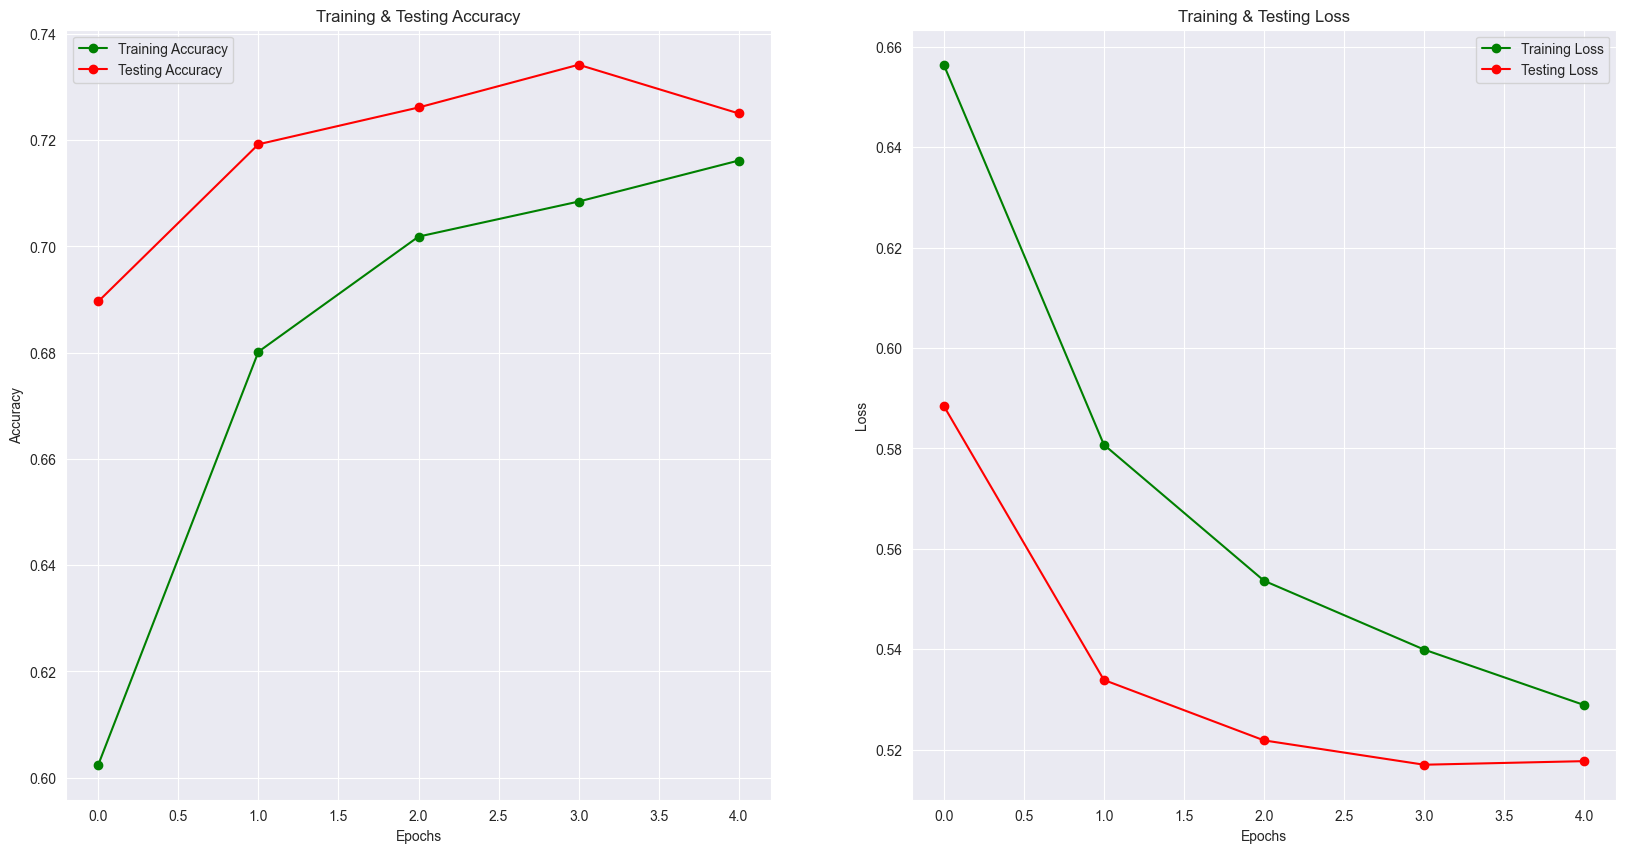

In [131]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history_gru_bi.history['acc']
train_loss = history_gru_bi.history['loss']
val_acc = history_gru_bi.history['val_acc']
val_loss = history_gru_bi.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()